In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
import scipy.stats as sp
from sklearn.model_selection import GridSearchCV as GS

In [2]:
def evaluateModel(prediction,actual):    
    prediction.plot(color='red', label='Prediction')
    actual.plot(color='blue', label='Actual')
    plt.legend(loc='best')
    prediction = np.array(prediction.tolist())
    actual = np.array(actual.tolist())
    print('Pearson Correlation Coeefiecient: ', sp.pearsonr(actual, prediction))
    error2 = [((x-y)/y)**2 for x, y in zip(prediction, actual)]
    print ("Normalised RMSE",np.sqrt(np.sum(error2)))

In [3]:
msft = pd.DataFrame.from_csv('MSFT.csv')
msft = msft.interpolate()
#changing the index to go from 1986 to 2016
msft = msft.reindex(index=msft.index[::-1])
investor = pd.DataFrame.from_csv('investor.csv')
investor = investor.fillna(investor.mean())
#changing the index to go from 1987 to 2016
investor = investor.reindex(index=investor.index[::-1])

## Processing msft stock data by averaging their weekly values to match the index of investor's weekly update

In [ ]:
weekholder1 = investor.drop(investor.index[-1]).index
weekholder2 = investor.drop(investor.index[0]).index

In [ ]:
Open = []
Close = []
High = []
Low = []
for week1, week2 in zip(weekholder1, weekholder2):
    Open.append(np.mean(msft.Open.loc[week1:week2]))
    Close.append(np.mean(msft.Close.loc[week1:week2]))
    High.append(np.mean(msft.High.loc[week1:week2]))
    Low.append(np.mean(msft.Low.loc[week1:week2]))

In [ ]:
msftweek = pd.DataFrame(index=weekholder2, data={'Open': Open, "Close":Close, "High":High, "Low":Low})

In [ ]:
cols = ['Open','Close','High','Low']
msftweek=msftweek[cols]
msftweek.head()

## Making new data to predict stock value ahead of time by making new features

In [ ]:
weekholder = msftweek.index
investor = investor.loc[weekholder]

In [ ]:
investor.index

In [ ]:
msftweek.index

In [ ]:
def makenewfeature(window, Series):
    name=Series.name
    index=[]
    mean=[]
    std=[]
    median=[]
    gradient=[]
    for count in range(len(weekholder)):
        frame=count+window
        if(frame<len(weekholder)):
            index.append(weekholder[frame])
            mean.append(np.mean(Series[count:frame]))
            std.append(np.std(Series[count:frame]))
            median.append(np.median(Series[count:frame]))
            gradient.append(np.mean(np.gradient(Series[count:frame])))
    df = pd.DataFrame(index=index, data={name+'_mean': mean, name+"_std":std, name+"_median":median, name+"_gradient":gradient})
    return df

In [ ]:
statsOpen = makenewfeature(9, msftweek.Open)
statsBullish = makenewfeature(9, investor.Bullish)
statsNeutral = makenewfeature(9, investor.Neutral)
statsBearish = makenewfeature(9, investor.Bearish)

In [ ]:
frames = [statsOpen, statsBullish, statsNeutral, statsBearish]
newfeatures = pd.concat(frames, axis=1)
newfeatures.head()

In [ ]:
newfeatures.to_csv("newfeat_9.csv")

## now lets Random Forest on this new data but lets first split it into 80:20 train:test

In [4]:
newfeatures = pd.read_csv("newfeat_9.csv", index_col=0)
msftweek = pd.read_csv("MSFT_weekly.csv", index_col=0)
expected = msftweek.loc[newfeatures.index]
expected.head()

,Open,Close,High,Low
1987-09-18,116.916667,116.855000,118.250000,115.208333
1987-09-25,67.041667,68.208333,69.936667,66.500000
1987-10-02,64.541667,66.250000,67.270000,64.228333
1987-10-09,73.500000,73.666667,75.958333,71.396667
1987-10-16,71.791667,70.500000,74.041667,69.458333


In [5]:
trainData = newfeatures[:(int)(len(newfeatures)*0.8)]
testData = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutput = expected.Open[:(int)(len(newfeatures)*0.8)]
testOutput = expected.Open[(-(int)(len(newfeatures)*0.2)):]

In [7]:
params =[ {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],},
         {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],} 
        ]

In [8]:
randomForestRegression = RFR()
gridsearch = GS(randomForestRegression, param_grid=params)
gridsearch.fit(trainData,trainOutput)
gridsearch.best_params_

/Users/chuanfuyap/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'mae',
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'oob_score': False}

In [11]:
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'mae',
 max_features= 'auto',
 min_samples_leaf= 3,
 min_samples_split= 2,
 oob_score= False)

In [12]:
randomForestRegression.fit(trainData,trainOutput)

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

('Pearson Correlation Coeefiecient: ', (0.99565222245184115, 0.0))
('Normalised RMSE', 1.7680848545336609)


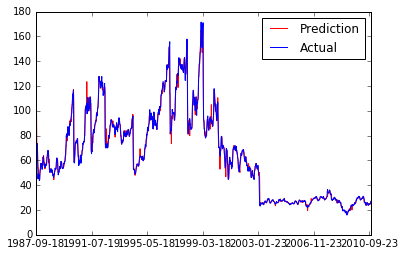

In [13]:
prediction = randomForestRegression.predict(trainData)
prediction = pd.Series(prediction, trainData.index)
evaluateModel(prediction,trainOutput)

('Pearson Correlation Coeefiecient: ', (0.78594387599072857, 1.33678045360951e-64))
('Normalised RMSE', 2.8918030689260479)


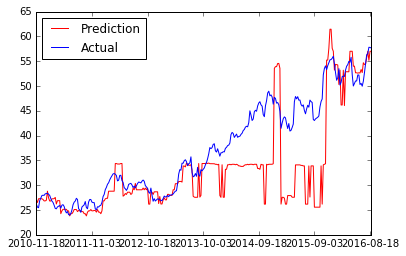

In [21]:
prediction = randomForestRegression.predict(testData)
prediction = pd.Series(prediction, testData.index)
evaluateModel(prediction,testOutput)

that worked a lot better, now lets try classification

In [25]:
Clf = []
previousday=msftweek.Open[0]
for stock in msftweek.Open[1:]:    
    if (stock > previousday):
        Clf.append(1)
    else:
        Clf.append(-1)
    previousday = stock

In [35]:
Clf = pd.Series(Clf , index=msftweek.index[1:])
Clf=Clf[newfeatures.index]

In [36]:
trainClf = Clf[:(int)(len(newfeatures)*0.8)]
testClft = Clf[(-(int)(len(newfeatures)*0.2)):]

In [37]:
params2 =[ {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],},
         {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],}
        ]

In [38]:
randomForestClassifier = RFC()
gridsearch = GS(randomForestClassifier, param_grid=params2)
gridsearch.fit(trainData,trainClf)
gridsearch.best_params_

/Users/chuanfuyap/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'oob_score': False}

In [41]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'entropy',
 max_features= 'auto',
 min_samples_leaf= 3,
 min_samples_split= 3,
 oob_score= False
    )

In [42]:
randomForestClassifier.fit(trainData,trainClf)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
prediction = randomForestClassifier.predict(trainData)

from __future__ import division

trackright=0
for x , y in zip(prediction, trainClf):
    if (x==y):
        trackright+=1
trackright/len(trainClf)

1.0